# Visión por Computadora 2025
#           Lab 1
### Juan Luis Solórzano carnet: 201598
### Diego Alonzo - 20172

In [1]:
!pip freeze > requirements.txt

In [17]:
import numpy as np
from extras import*
import matplotlib.pyplot as plt
from skimage.filters.thresholding import threshold_isodata, threshold_li, threshold_local, threshold_mean, threshold_minimum, threshold_multiotsu, threshold_niblack, threshold_otsu, threshold_sauvola, threshold_triangle
import skimage as ski
from PIL import Image
import cv2 as cv

In [3]:
riz = plt.imread('walk.jpg')
riz = ski.color.rgb2gray(riz[:,:,:3])

riz = (riz*255).astype(np.uint8)
riz.shape

(1621, 2369)


### 1. Ecualización de histograma

Implementar en Python una función que haga la ecualización de histograma para una imagen en escala de grises (8 bits). 

- Mostrar la imagen original y la imagen ecualizada.
- Mostrar también los histogramas normalizados y su distribución acumulada de ambas imágenes.
- Comparar los resultados de su función contra alguna función ya predefinida en Python (por ejemplo, `skimage.exposure.equalize_hist` o `cv2.equalizeHist`).
- Explicar las diferencias o similitudes entre ambas implementaciones.




In [4]:
def ecualizar(Im):
    L, C = Im.shape  #dimension foto
    n = L * C  # pixeles de la foto
    
    # comando histograma de la foto
    f, b = np.histogram(Im, bins=256, range=(0, 255))
    b = np.round(b).astype(np.uint8)
    # Normalizar 
    fn = f / n  
    
    # Calcular la función de distribución acumulativa (CDF)
    Fn = np.cumsum(fn)
    
    fe = np.zeros(256)
    #algorithmo de ecualisación
    be = np.round(Fn * 255).astype(np.uint8)
    s = 0 
    mem = -1
    j = 0
    for i in be:
        if mem != i:
            s = Fn[i]
            fe[i] = fn[j]
            mem = i
        
        j +=1
    Fe = np.cumsum(fe)        
    # Aplicar la transformación a la imagen
    I = Im.copy()
    for i in range(L):
        for j in range(C):
            I[i, j] = be[Im[i, j]]
    v0 = (Im, b[:256],fn,Fn)
    v1 = (I,b[:256],fe,Fe)
    
    return v0,v1  # Devolver la imagen ecualizada (I), la original (IM) con sus distribuciones. acumuladas
oF, eF = ecualizar(riz)
Ie = ski.exposure.equalize_hist(riz, nbins=256, mask=None)
Ie = (Ie * 255).astype(np.uint8)

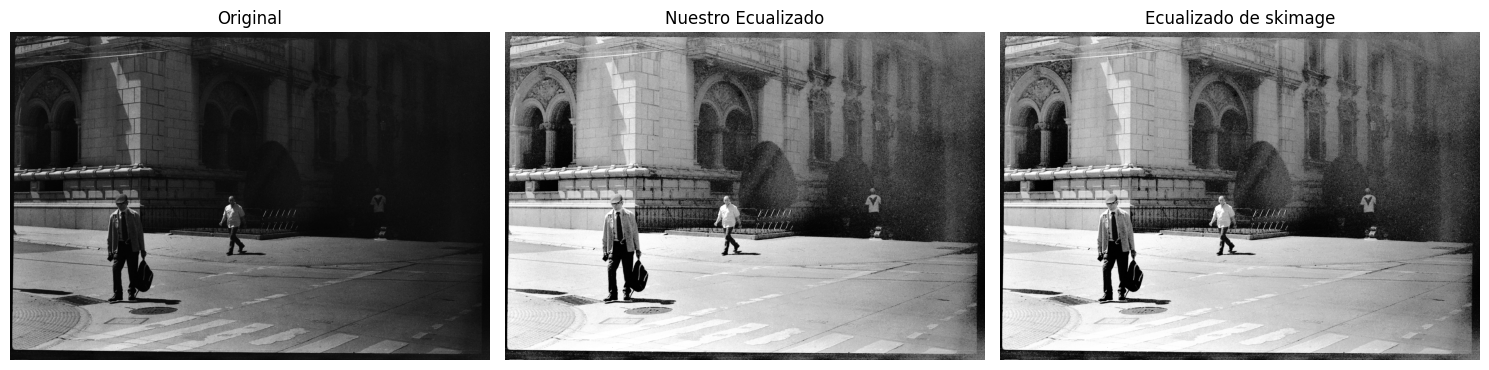

In [5]:
 mostrar_imagenes(['Original', 'Nuestro Ecualizado', 'Ecualizado de skimage'],[oF[0], eF[0], Ie])

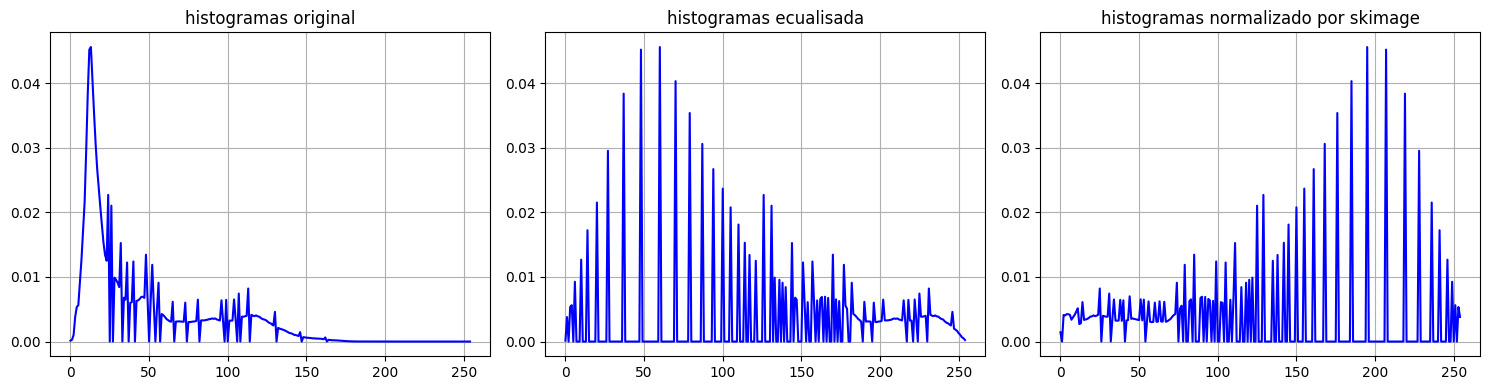

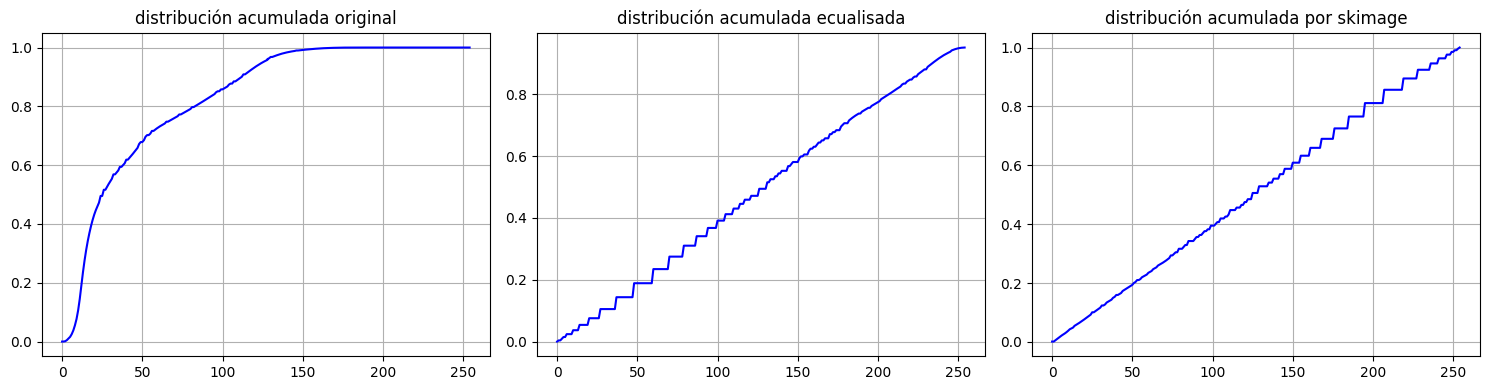

In [6]:
Ie = (Ie * 255).astype(np.uint8)
f , x = np.histogram(Ie, bins=256, range=(0, 255))
x = np.round(x).astype(np.uint8)
L, C = Ie.shape
f = f/ (C*L)
F = np.cumsum(f)
datos = [(oF[1],oF[2]),(eF[1],eF[2]),(oF[1],f)]
titulos = ['histogramas original','histogramas ecualisada','histogramas normalizado por skimage']
mostrar_graficas(datos, titulos)
datos = [(oF[1],oF[3]),(eF[1],eF[3]),(oF[1],F)]
titulos = ['distribución acumulada original','distribución acumulada ecualisada','distribución acumulada por skimage']
mostrar_graficas(datos, titulos)


### 2. Segmentación binaria de imágenes

Implementar 3 algoritmos para segmentación binaria de imágenes. Uno de estos debe ser un algoritmo local.

- Aplicar cada algoritmo a al menos 3 imágenes en escala de grises.
- Comparar los resultados obtenidos visualmente.
- Concluir cuál de los algoritmos obtiene mejores resultados.



In [7]:
riz = plt.imread('rice.jpg')
riz = ski.color.rgb2gray(riz[:,:,:3])

riz = (riz*255).astype(np.uint8)

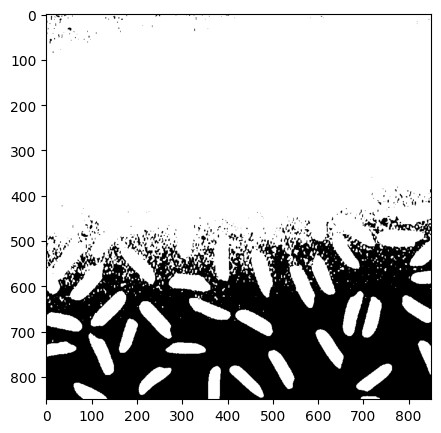

i= 4
t= 130.7709694525372


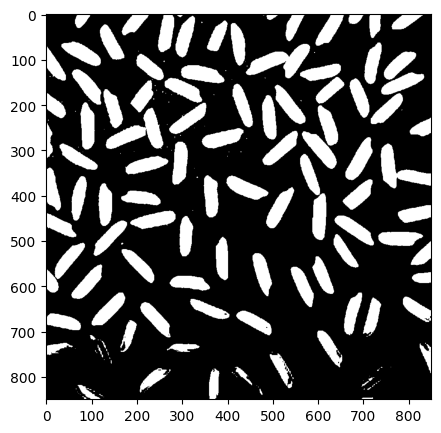

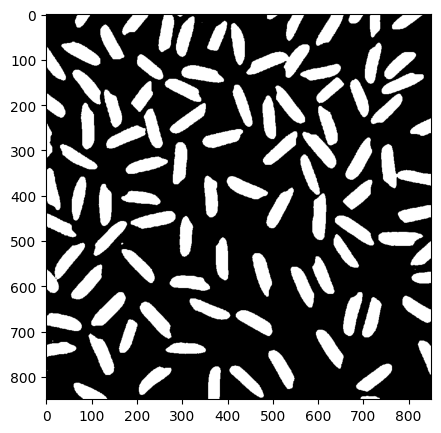

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def Th(I, t):
    I = I.copy()  # Evitar modificar la imagen original
    I[I < t] = 0
    I[I >= t] = 255
    return I

def ThRC(I, t=123):
    if t <= I.min() or t >= I.max():
        t = np.mean([I.min(), I.max()])  # Corregido el cálculo de t inicial

    tm = t + 1
    i = 0
    while abs(tm - t) > 1e-6 and i < 9:  # Corregida la condición de parada
        B = I[I < t]
        F = I[I > t]
        
        # Evitar división por cero si B o F están vacíos
        mB = np.mean(B) if B.size > 0 else 0
        mF = np.mean(F) if F.size > 0 else 255
        
        tm = t
        t = (mB + mF) / 2
        i += 1

    return Th(I, t), t, i  # Asegurar que se devuelve la imagen binarizada

def ThLocal(I, h, w):
    h //= 2
    w //= 2
    H, W = I.shape
    Th = np.full((H, W), 100, dtype=np.uint8)  
    I2 = np.zeros((H, W), dtype=np.uint8)

    for i in range(H):
        for j in range(W):
            i_min, i_max = max(0, i - h), min(H, i + h + 1)
            j_min, j_max = max(0, j - w), min(W, j + w + 1)
            
            Iw = I[i_min:i_max, j_min:j_max]

            if Iw.size == 0:
                continue

            _, Th[i, j], _ = ThRC(Iw)  # Corregido para ignorar la imagen binarizada
            I2[i, j] = 255 if I[i, j] > Th[i, j] else 0  # Corregido el umbral binario

    return I2, Th

# Cargar imagen de prueba (asegurar que `riz` está definido como imagen en escala de grises)
#riz = np.random.randint(0, 256, (100, 100), dtype=np.uint8)  # Ejemplo de imagen aleatoria

I01 = Th(riz, 90)
plt.figure(figsize=(5,5))
plt.imshow(I01, cmap='gray')
plt.show()

I01, t, i = ThRC(riz)
print('i=', i)
print('t=', t)
plt.figure(figsize=(5,5))
plt.imshow(I01, cmap='gray')
plt.show()

I01, Th = ThLocal(riz, 30, 300)
plt.figure(figsize=(5,5))
plt.imshow(I01, cmap='gray')
plt.show()


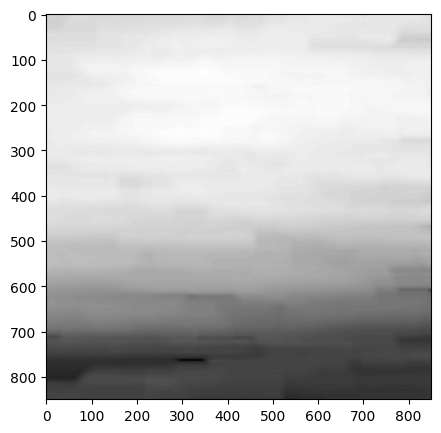

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(Th, cmap='gray')
plt.show()

### 3. Segmentación en imágenes RGB con k-medias

Implementar un algoritmo de segmentación para imágenes RGB utilizando el algoritmo de k-medias.

- Permitir al usuario elegir el parámetro k (k ≥ 2).
- Mostrar ejemplos de segmentación con:
  - Imagen original.
  - Mapa de segmentos o clases.
  - Imagen cuantizada (promedio de color en cada segmento).
- Presentar al menos dos ejemplos buenos y dos malos, explicando sus alcances y limitaciones.



### 4. Análisis de cromaticidad

- Convertir las imágenes `coca-cola.jpeg` y `pepsi.png` de RGB a un espacio de color cromático adecuado.
- Elaborar el histograma del canal de cromaticidad.
- Analizar el histograma y concluir qué ocurre con los colores en cada imagen.



### 5. Segmentación binaria de granos de arroz

- Implementar un algoritmo que identifique correctamente todos los granos de arroz en la imagen `rice.png`.
- No se puede aplicar un método local.



shape: (850, 850, 3)
matrix: [[[126 126 126]
  [125 125 125]
  [121 121 121]
  ...
  [ 96  96  96]
  [ 92  92  92]
  [ 92  92  92]]

 [[125 125 125]
  [125 125 125]
  [120 120 120]
  ...
  [ 95  95  95]
  [ 92  92  92]
  [ 92  92  92]]

 [[122 122 122]
  [121 121 121]
  [117 117 117]
  ...
  [ 94  94  94]
  [ 92  92  92]
  [ 92  92  92]]

 ...

 [[ 56  56  56]
  [ 57  57  57]
  [ 57  57  57]
  ...
  [ 46  46  46]
  [ 47  47  47]
  [ 46  46  46]]

 [[ 59  59  59]
  [ 59  59  59]
  [ 58  58  58]
  ...
  [ 43  43  43]
  [ 41  41  41]
  [ 41  41  41]]

 [[ 60  60  60]
  [ 60  60  60]
  [ 58  58  58]
  ...
  [ 43  43  43]
  [ 41  41  41]
  [ 41  41  41]]]


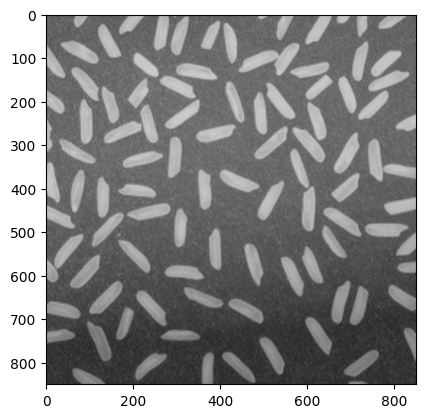

In [10]:
rice = plt.imread('rice.jpg')
print("shape:",rice.shape)
print("matrix:", rice)
plt.imshow(rice)

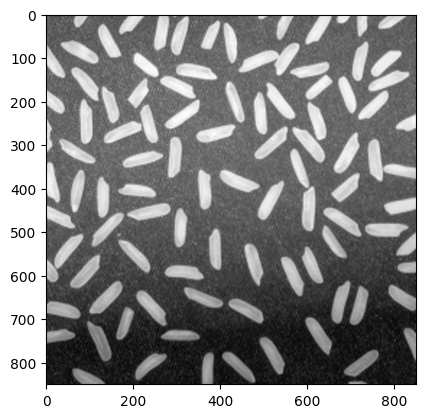

In [11]:
rice = ski.color.rgb2gray(rice[:,:,:3])
rice = (rice*255).astype(np.uint8)
plt.imshow(rice, cmap="gray")

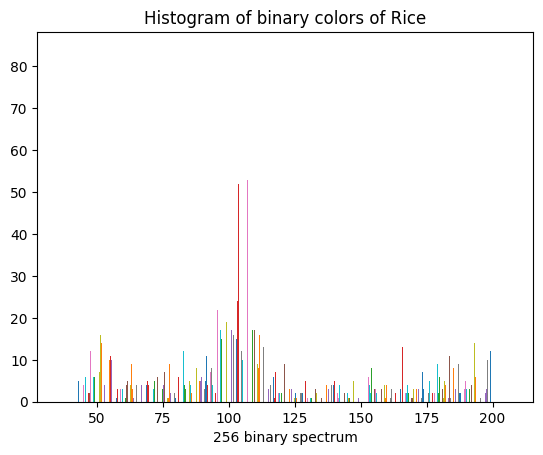

In [12]:
plt.hist(rice, bins=256)
plt.xlabel('256 binary spectrum')
plt.title('Histogram of binary colors of Rice')
plt.show()

In [13]:
h = np.histogram(rice, bins=256, range=(0,255))

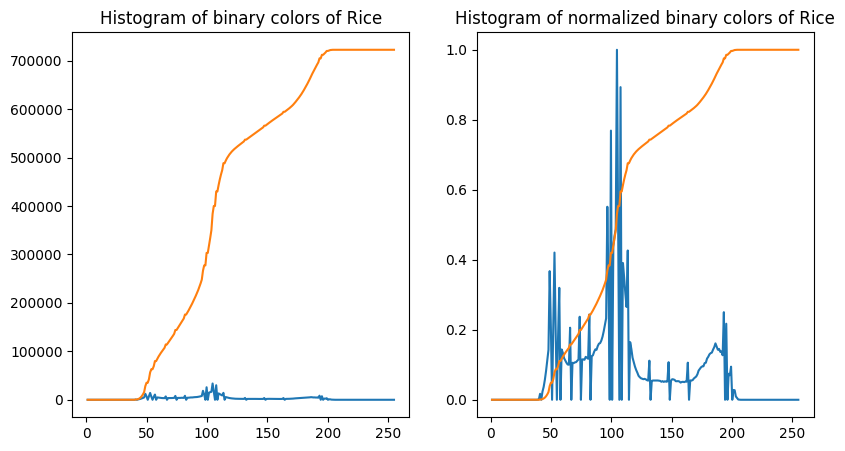

In [14]:
# Set a figure to put the histograms
plt.figure(figsize=(20,5))
# Put the coordinates 4 the histogram without normalization
plt.subplot(1,4,3)
plt.title('Histogram of binary colors of Rice')
plt.plot(h[1][1:], h[0]) # Ignoring the extra bin edge 
plt.plot(h[1][1:], h[0].cumsum()) # Plotting the cumulative values
plt.subplot(1,4,4)
# Put the coordinates 4 the histogram normalized
plt.title('Histogram of normalized binary colors of Rice')
plt.plot(h[1][1:], h[0]/h[0].max())
plt.plot(h[1][1:], h[0].cumsum() / (rice.shape[0] * rice.shape[1])) # Plotting the cumulative values per total pixels
plt.show()


In [15]:
def li_threshold(image, max_iterations=100, tolerance=1e-5):
    image = image.astype(np.float32)
    
    # Initialize threshold as mean intensity
    T = np.mean(image)
    
    for _ in range(max_iterations):
        # Separate background and foreground
        background = image[image < T]
        foreground = image[image >= T]
        
        # Avoid division by zero
        if len(background) == 0 or len(foreground) == 0:
            break
        
        # Compute means
        mu_b = np.mean(background)
        mu_f = np.mean(foreground)
        
        # Compute new threshold
        T_new = (mu_b - mu_f) / (np.log(mu_b) - np.log(mu_f))
        
        # Check for convergence
        if abs(T_new - T) < tolerance:
            break
        
        T = T_new

    return T
    

In [18]:
liTh = li_threshold(rice, 100000, tolerance=1e-10)
print(liTh)
riceLiTh = 255 * (rice >= liTh).astype(np.uint8)
liThSki = threshold_li(rice)
riceLiTh2 = 255 * (rice >= liThSki).astype(np.uint8)
print(liThSki)

124.710144
122.30975823571775


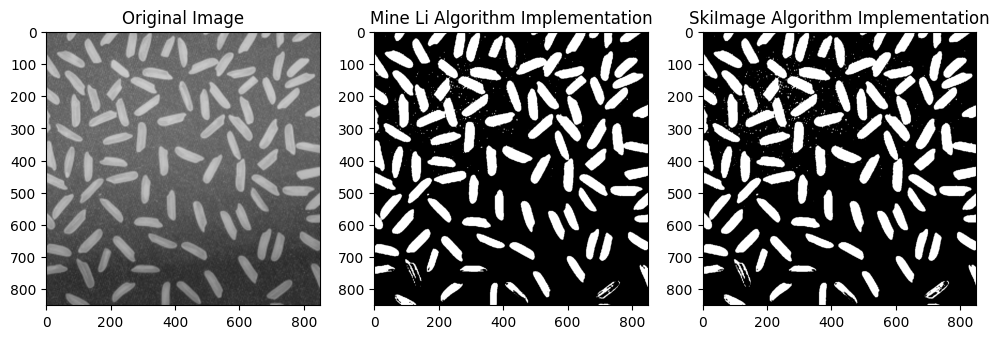

In [20]:
plt.figure(figsize=(12,7))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(rice, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,3,2)
plt.title("Mine Li Algorithm Implementation")
plt.imshow(riceLiTh, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,3,3)
plt.title("SkiImage Algorithm Implementation")
plt.imshow(riceLiTh2, cmap='gray', vmin=0, vmax=255)
plt.show()

Detected Objects: 325


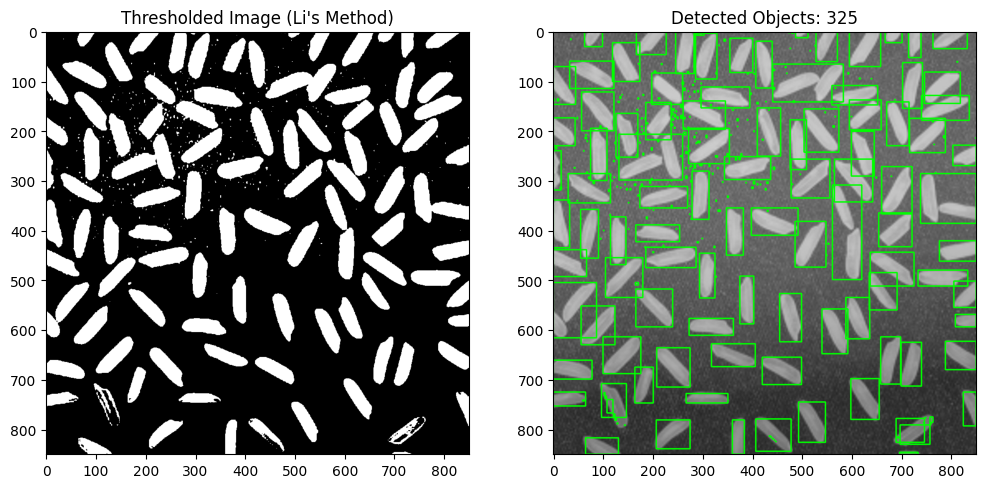

In [24]:
# Find contours (objects)
contours, _ = cv.findContours(riceLiTh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Count detected objects
object_count = len(contours)
print(f"Detected Objects: {object_count}")

# Draw bounding boxes around detected objects
output_image = cv.cvtColor(rice.astype(np.uint8), cv.COLOR_GRAY2BGR)  # Convert grayscale to BGR

for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    cv.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw green rectangle

# Convert OpenCV BGR to RGB for display
output_rgb = output_image[:, :, ::-1]

# Display Results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Thresholded Image (Li's Method)")
plt.imshow(riceLiTh2, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Detected Objects: {object_count}")
plt.imshow(output_rgb)

plt.show()


### 6. Detección de color en tiempo real

- Implementar un detector de color amarillo (`YELLOW`) en tiempo real usando OpenCV.
- Capturar imágenes directamente de la cámara de la PC.
- Mostrar el resultado de la detección en tiempo real en pantalla.
- Se puede diseñar el detector para detectar otros colores diferentes.
- Incluir capturas de pantalla con ejemplos de su funcionamiento.

